## Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import time
from miner import miner, subtypes, causal_inference as causalinf

## Create directory to save output files

In [2]:
# Path to the miner directory
proj_path = os.path.join(os.path.expanduser('~'),'Projects','miner3')
input_path = os.path.join(proj_path, 'miner_mindata')

# create name for results folder where output files will be saved
resultsFolder = "results_miner"

# create results directory
resultsDirectory = os.path.join(proj_path,resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)
# name of the folder containing the miner network
network_path = os.path.join(proj_path, "miner_network_results")

## Load primary data

In [3]:
# Load expression Data
expressionFile = os.path.join(input_path, "expression", "IA12Zscore.csv")
id_names = os.path.join(input_path, "identifier_mappings.txt")
expressionData, conversionTable = miner.preprocess(expressionFile, id_names)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path, 'mutations', 'commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path, 'mutations', 'translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path, 'mutations', 'cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(network_path,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(network_path,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(network_path,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(network_path,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(network_path,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(network_path, "overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(network_path, "underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(network_path, "eigengenes.csv"), index_col=0, header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

#Load table for converting gene names
id_table = pd.read_csv(id_names, sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

completed identifier conversion.
16216 genes were converted. 10285 genes were dropped due to identifier mismatch


## Load network

In [4]:
# Load Causal Mechanistic Network
filtered_causal_results = pd.read_csv(os.path.join(network_path, "filteredCausalResults.csv"),index_col=0,header=0)

In [5]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(network_path, 'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

In [6]:
# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(network_path, 'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

## Load primary survival data

In [7]:
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(input_path,"survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

## Figures

In [8]:
#set figure style
sns.set(font_scale=1.4,style="whitegrid")

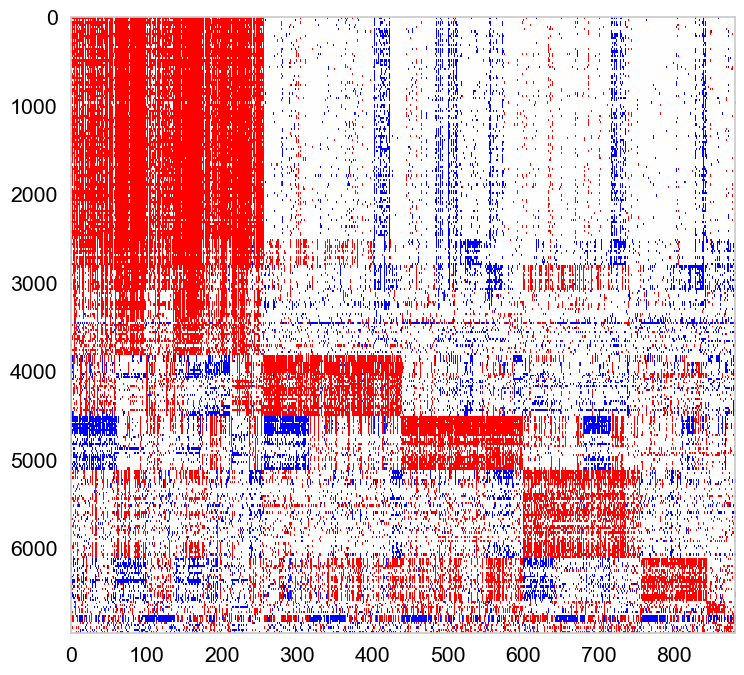

In [9]:
# Regulon activity heatmap
plt.figure(figsize=(8.57,8))
plt.imshow(diff_matrix_MMRF.loc[np.hstack(program_list),np.hstack(states_list)],
          cmap="bwr",vmin=-1,vmax=1,aspect="auto",interpolation='none')
plt.grid(False)

ax = plt.gca()
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.savefig(os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),bbox_inches="tight")

## Survival analysis of regulons

In [10]:
# Cox proportional hazards regression of transcriptional programs
t1 = time.time()

cox_regulons_output = miner.parallelMedianSurvivalAnalysis(regulonModules,expressionData,guanSurvivalDfMMRF,numCores=5)
cox_regulons_output = cox_regulons_output.iloc[np.argsort(np.array(cox_regulons_output.index).astype(int))]
cox_regulons_output.to_csv(os.path.join(resultsDirectory,'CoxProportionalHazardsRegulons.csv'))
cox_regulons_output.sort_values(by="HR",ascending=False,inplace=True)

print("\nHigh-risk regulons:")
print(cox_regulons_output.iloc[0:5,:])
print("\nLow-risk regulons")
print(cox_regulons_output.iloc[-5:,:])

t2 = time.time()
print("Completed regulon risk analysis in {:.2f} minutes".format((t2-t1)/60.))
      

Completed 0 of 1392 iterations
Completed 100 of 1392 iterations
Completed 200 of 1392 iterations
Completed 300 of 1392 iterations
Completed 400 of 1392 iterations
Completed 500 of 1392 iterations
Completed 600 of 1392 iterations
Completed 700 of 1392 iterations
Completed 800 of 1392 iterations
Completed 900 of 1392 iterations
Completed 1000 of 1392 iterations
Completed 1100 of 1392 iterations
Completed 1200 of 1392 iterations
Completed 1300 of 1392 iterations
Completed 0 of 1392 iterations
Completed 100 of 1392 iterations
Completed 200 of 1392 iterations
Completed 300 of 1392 iterations
Completed 400 of 1392 iterations
Completed 500 of 1392 iterations
Completed 600 of 1392 iterations
Completed 700 of 1392 iterations
Completed 800 of 1392 iterations
Completed 900 of 1392 iterations
Completed 1000 of 1392 iterations
Completed 1100 of 1392 iterations
Completed 1200 of 1392 iterations
Completed 1300 of 1392 iterations
Completed 0 of 1392 iterations
Completed 100 of 1392 iterations
Complete

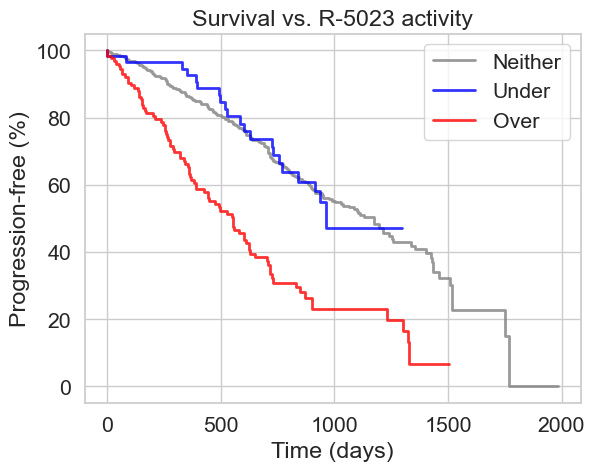

In [11]:
# Explore survival versus regulon activity
key = cox_regulons_output.index[0]
output_file = os.path.join(resultsDirectory,"regulon_"+key+"_survival.pdf")
regulon_cox_results = miner.regulon_survival(key,diff_matrix_MMRF,guanSurvivalDfMMRF,filename=output_file,title="Survival vs. R-"+key+" activity")

## Survival analysis of transcriptional programs

In [12]:
# Create dictionary of program genes
# make dictionary of genes by program
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes

In [13]:
referenceDictionary = pr_genes
# create a background matrix used for statistical hypothesis testing
bkgd = miner.background_df(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

# write membership matrices to .csv file
overExpressedMembersMatrix_pr = miner.membershipToIncidence(overExpressedMembers_pr,expressionData)
underExpressedMembersMatrix_pr = miner.membershipToIncidence(underExpressedMembers_pr,expressionData)


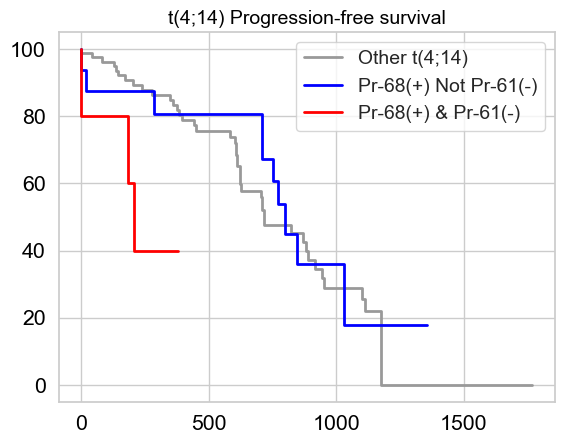

In [14]:
# Substratify t(4;14)
t414_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
pr68_up = miner.getMutations(68,overExpressedMembersMatrix_pr)
pr61_dn = miner.getMutations(61,underExpressedMembersMatrix_pr)

# Pr-68(+), Pr-61(-)
pr68up_pr61dn = miner.intersect(pr68_up,pr61_dn)
pr68up_not_pr61dn = miner.setdiff(pr68_up,pr61_dn)

# Subset to t(4;14)
pr68up_pr61dn = miner.intersect(pr68up_pr61dn,t414_patients)
pr68up_not_pr61dn = miner.intersect(pr68up_not_pr61dn,t414_patients)
other_t414 = miner.setdiff(t414_patients,miner.union(pr68up_pr61dn,pr68up_not_pr61dn))

#plot comparison
srv = guanSurvivalDfMMRF.copy()
groups = [other_t414,pr68up_not_pr61dn,pr68up_pr61dn]
labels = ["Other t(4;14)","Pr-68(+) Not Pr-61(-)","Pr-68(+) & Pr-61(-)"]
colors = [[0.6,0.6,0.6],"blue","red"]
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color=colors,alpha=1)  
plt.title("t(4;14) Progression-free survival",fontsize=14,color="black")
plt.legend(frameon=True,fontsize="small")
plt.ylabel(None)
plt.xlabel(None)

ax = plt.gca()
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

#save figure
plt.savefig(os.path.join(resultsDirectory,"kmplots_t414.pdf"),bbox_inches="tight")

In [15]:
# Cox proportional hazards regression of transcriptional programs
t1 = time.time()

cox_programs_output = miner.parallelMedianSurvivalAnalysis(pr_genes,expressionData,guanSurvivalDfMMRF,numCores=5)
cox_programs_output = cox_programs_output.iloc[np.argsort(np.array(cox_programs_output.index).astype(int))]
cox_programs_output.to_csv(os.path.join(resultsDirectory,'CoxProportionalHazardsPrograms.csv'))
cox_programs_output.sort_values(by="HR",ascending=False,inplace=True)

print("\nHigh-risk programs:")
print(cox_programs_output.iloc[0:5,:])
print("\nLow-risk programs")
print(cox_programs_output.iloc[-5:,:])

t2 = time.time()
print(t2-t1)

Completed 0 of 25 iterations
Completed 0 of 25 iterations
Completed 0 of 25 iterations
Completed 0 of 25 iterations
Completed 0 of 26 iterations

High-risk programs:
          HR       p-value
50  9.199234  3.605093e-20
47  8.644961  5.382359e-18
45  8.630964  6.083719e-18
62  8.411196  4.058498e-17
51  8.396874  4.585208e-17

Low-risk programs
          HR   p-value
35 -3.507526  0.000452
28 -3.586944  0.000335
32 -3.760109  0.000170
37 -4.133993  0.000036
17 -4.158379  0.000032
4.0944108963012695


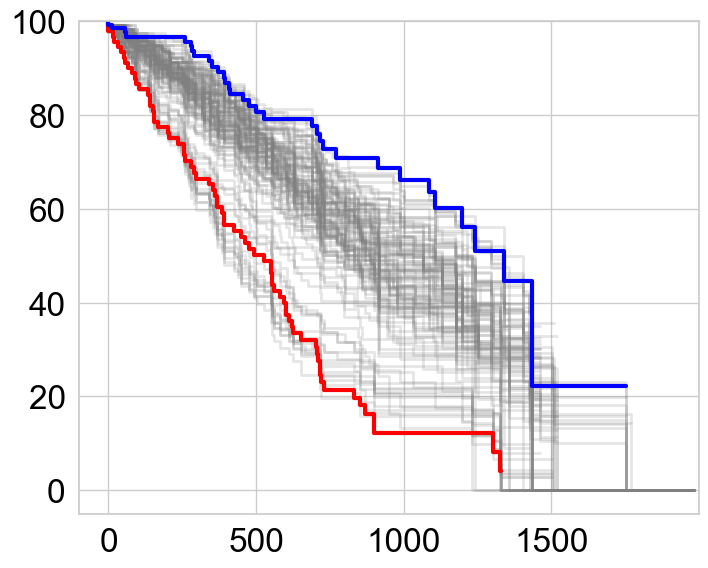

In [16]:
# Kaplan-Meier plot of all programs (median expression)
srv = guanSurvivalDfMMRF.copy()
keys = list(pr_genes.keys())

plt.figure(figsize=(8,6.4))
plt.xlim(-100,2000)
for key in keys:
    cluster = np.array(expressionData.loc[pr_genes[key],:])
    median_ = np.mean(cluster,axis=0)
    threshold = np.percentile(median_,85)
    median_[median_>=threshold] = 1
    median_[median_<threshold] = 0
    membership_df = pd.DataFrame(median_)
    membership_df.index = expressionData.columns
    membership_df.columns = [key]

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

    groups = [membership_df.index[np.where(membership_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]
    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color=["gray"],alpha=0.2)  


key_min = cox_programs_output.index[0]
key_max = cox_programs_output.index[-1]

cluster = np.array(expressionData.loc[pr_genes[key_min],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_min]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_min]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=3,color=["red"],alpha=1)  

    
cluster = np.array(expressionData.loc[pr_genes[key_max],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_max]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_max]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=3,color=["blue"],alpha=1) 

plt.ylim(-5,100)
plt.xticks(np.arange(0,2000,500),fontsize=24)
plt.yticks(np.arange(0,100.05,20),fontsize=24)

plt.xlabel(None)
plt.ylabel(None)

ax = plt.gca()
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.savefig(os.path.join(resultsDirectory,"kmplots_programs.pdf"),bbox_inches="tight")

## Survival analysis of transcriptional states

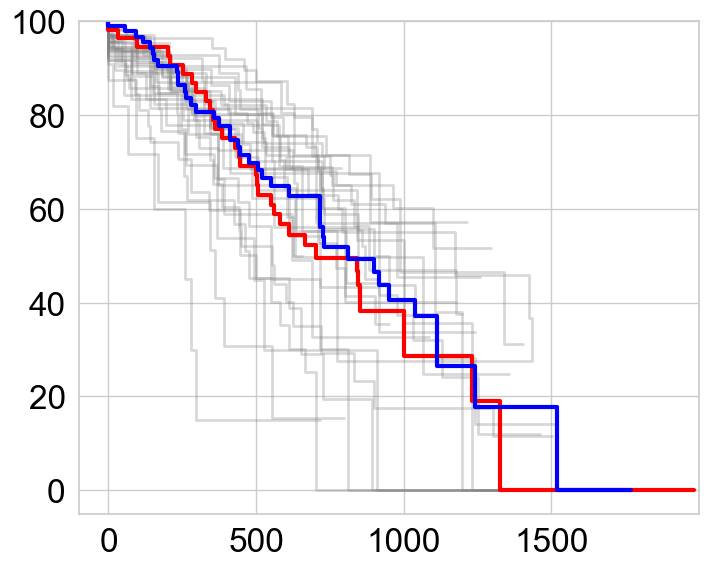

In [17]:
# Kaplan-Meier plot of all programs (median expression)
plt.figure(figsize=(8,6.4))
#plt.style.use('seaborn-whitegrid')
plt.xlim(-100,2000)

srv = guanSurvivalDfMMRF.copy()
for key in range(len(states_list)):

    median_df = pd.DataFrame(np.zeros(expressionData.shape[1]))
    median_df.index = expressionData.columns
    median_df.columns = [key]
    median_df.loc[states_list[key],key] = 1

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(median_df,guanSurvivalDfMMRF)

    groups = [median_df.index[np.where(median_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color=["gray"],alpha=0.3)  


# highlight_list = [
#                  np.hstack([states_list[4],states_list[5],states_list[16],states_list[23]])]

highlight_list = [
                 np.hstack([states_list[10],states_list[14],states_list[21]])]

for key in range(len(highlight_list)):
    median_df = pd.DataFrame(np.zeros(expressionData.shape[1]))
    median_df.index = expressionData.columns
    median_df.columns = [key]
    median_df.loc[highlight_list[key],key] = 1

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(median_df,guanSurvivalDfMMRF)

    groups = [median_df.index[np.where(median_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=3,color=["red"],alpha=1)  
    
# Combine high-risk states
# highlight_list = [
#                  np.hstack([states_list[10],states_list[14],states_list[21]])]

highlight_list = [
                 np.hstack([states_list[4],states_list[5],states_list[16],states_list[23]])]

for key in range(len(highlight_list)):
    median_df = pd.DataFrame(np.zeros(expressionData.shape[1]))
    median_df.index = expressionData.columns
    median_df.columns = [key]
    median_df.loc[highlight_list[key],key] = 1

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(median_df,guanSurvivalDfMMRF)

    groups = [median_df.index[np.where(median_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=3,color=["blue"],alpha=1)  

plt.ylim(-5,100)
plt.xticks(np.arange(0,2000,500),fontsize=24)
plt.yticks(np.arange(0,100.05,20),fontsize=24)
plt.xlabel(None)
plt.ylabel(None)

ax = plt.gca()
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.savefig(os.path.join(resultsDirectory,"kmplots_states.pdf"),bbox_inches="tight")

## Generate boxplot data for transcriptional states

In [18]:
survival_patients = list(guanSurvivalDfMMRF.index)
t414_patients = translocations.columns[
    np.where(translocations.loc["RNASeq_WHSC1_Call",:]==1)[0]
]
t1114_patients = translocations.columns[
    np.where(translocations.loc["RNASeq_CCND1_Call",:]==1)[0]
]

min_patients = 5
ranks = []
boxplot_data = []
boxplot_names = []
boxplot_samples = []
boxplot_labels = []
percent_t414 = []
percent_t1114 = []
for key in range(len(states_list)):
    state = states_list[key]
    overlap_patients = list(set(survival_patients)&set(state))
    if len(overlap_patients) < min_patients:
        continue
    guan_data = list(guanSurvivalDfMMRF.loc[overlap_patients,"GuanScore"])
    boxplot_samples.append(overlap_patients)
    boxplot_data.append(guan_data)
    boxplot_names.append([1+key for i in range(len(overlap_patients))])
    risk_score = np.median(guan_data)
    ranks.append(risk_score)
    
    t414_overlap = len(set(state)&set(t414_patients))
    t1114_overlap = len(set(state)&set(t1114_patients))
    percent_t414_ = float(t414_overlap)/len(state)
    percent_t1114_ = float(t1114_overlap)/len(state)
    percent_t414.append(percent_t414_)
    percent_t1114.append(percent_t1114_)
ranks            

#Format labels into dataframe
labels = np.hstack([boxplot_names[i] for i in list(np.argsort(ranks))])
labels_df = pd.DataFrame(labels)
labels_df.index = np.hstack([boxplot_samples[i] for i in list(np.argsort(ranks))])
labels_df.columns = ["label"]
plot_data = pd.concat([guanSurvivalDfMMRF.loc[labels_df.index,"GuanScore"],labels_df],axis=1)

rank_order = np.array(list(set(np.hstack(boxplot_names))))[np.argsort(ranks)]
ranked_t414 = np.array(percent_t414)[np.argsort(ranks)]
ranked_t1114 = np.array(percent_t1114)[np.argsort(ranks)]

## Violin plots by states

/var/folders/dc/ffvymtgn3s1bh0h4gbbkg4cm0000gn/T/ipykernel_59367/419933658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="label", y="GuanScore", data=plot_data,


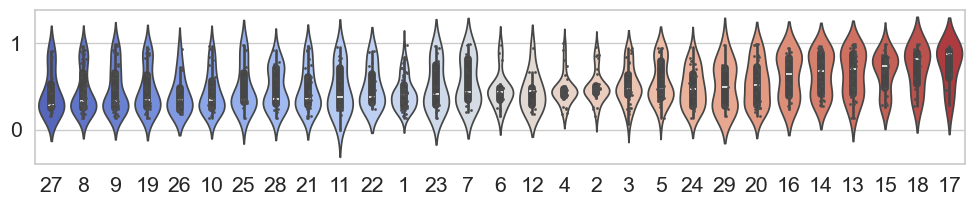

In [19]:
f, ax = plt.subplots(figsize=(12, 2))

# Plot the orbital period with horizontal boxes
sns.violinplot(x="label", y="GuanScore", data=plot_data,
               #fliersize=0,
                palette="coolwarm",order=rank_order)

# Add in points to show each observation
sns.stripplot(x="label", y="GuanScore", data=plot_data,
              size=2, color=".3", linewidth=0,order=rank_order)

# Tweak the visual presentation
ax.set(ylabel="")
ax.set(xlabel="")

# Save figure
plt.savefig(os.path.join(resultsDirectory,"violin_states_risk.pdf"),bbox_inches="tight")

## Boxplots by states

/var/folders/dc/ffvymtgn3s1bh0h4gbbkg4cm0000gn/T/ipykernel_59367/3478271562.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="GuanScore", data=plot_data,fliersize=0,


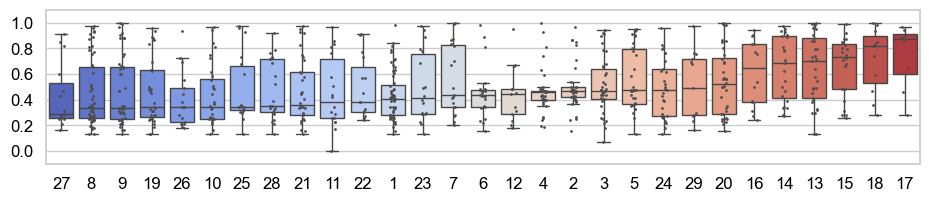

In [20]:
f, ax = plt.subplots(figsize=(11.27, 2))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="label", y="GuanScore", data=plot_data,fliersize=0,
            palette="coolwarm",order=rank_order)

# Add in points to show each observation
sns.stripplot(x="label", y="GuanScore", data=plot_data,
              size=2, color=".3", linewidth=0,
              order=rank_order)

# Tweak the visual presentation
ax.set(ylabel="")
ax.set(xlabel="")
ax.set(ylim=(-0.1,1.1))
ax.set(yticks=np.arange(0,1.05,0.2))
ax.tick_params(labelsize=12)
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

# Save figure
plt.savefig(os.path.join(resultsDirectory,"boxplot_states_risk.pdf"),bbox_inches="tight")

## t(4;14) and t(11;14) subtypes by states

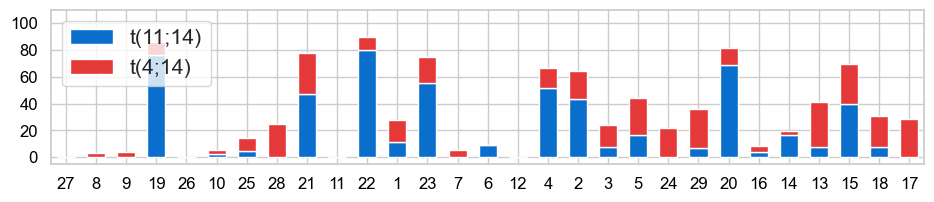

In [21]:
plt.figure(figsize=(11.27, 2))

N = len(ranks)
ind = np.arange(N)    # the x locations for the groups
w = 0.6
p1 = plt.bar(ind, 100*ranked_t1114,width=w,color='#0A6ECC',edgecolor="white",alpha=1)
p2 = plt.bar(ind, 100*ranked_t414,
             bottom=100*ranked_t1114,width=w,color='#E53939',edgecolor="white",alpha=1)

plt.xlim(-0.5,N-0.5)
plt.ylim(-5,110)
plt.yticks(np.arange(0,105,20),fontsize = 12)
plt.xticks(ticks=range(len(rank_order)),labels=list(rank_order),fontsize = 12)
plt.legend((p1[0], p2[0]), ('t(11;14)', 't(4;14)'),loc="upper left")

ax = plt.gca()
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.savefig(os.path.join(resultsDirectory,"barplot_states_translocations.pdf"),bbox_inches="tight")